In [1]:
import pyreadr
import scanpy as sc
import numpy as np
import os
import pandas as pd
import anndata as ad
import scrublet as scr
from pathlib import Path

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

In [2]:
# where to save the file and filename to give
DIR2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/20mt/scrublet_qc/")
scrublet_filename = "Lee2020_KUL_CRC_scrublet.txt"

# figures path to save
FIG2SAVE = DIR2SAVE.joinpath("figures/")
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

In [3]:
DIR2SAVE.mkdir(parents=True, exist_ok=True)
FIG2SAVE.mkdir(parents=True, exist_ok=True)

In [4]:
adata = sc.read_h5ad(
    "/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/raw/Lee2020_KUL_CRC_raw.h5ad"
)

In [5]:
set(adata.obs.Tissue)

{'CRC'}

In [6]:
len(set(adata.obs.Patient))

6

### run scrublet per sample and on raw data
* When working with data from multiple samples, run Scrublet on each sample separately. Because Scrublet is designed to detect technical doublets formed by the random co-encapsulation of two cells, it may perform poorly on merged datasets where the cell type proportions are not representative of any single sample.

In [7]:
adata.obs

,Patient,Class,Sample,Cell_type,Cell_subtype,cell_source,Tissue,Therapy
Index,,,,,,,,
KUL01-T_AAACCTGGTCTTTCAT,KUL01,Tumor,KUL01-T,Epithelial cells,CMS1,KUL,CRC,naive
KUL01-T_AAACGGGTCGGTTAAC,KUL01,Tumor,KUL01-T,Epithelial cells,CMS3,KUL,CRC,naive
KUL01-T_AAAGATGGTATAGGGC,KUL01,Tumor,KUL01-T,Epithelial cells,CMS3,KUL,CRC,naive
KUL01-T_AAAGATGGTGGCCCTA,KUL01,Tumor,KUL01-T,Epithelial cells,CMS1,KUL,CRC,naive
KUL01-T_AAAGCAAGTAAACACA,KUL01,Tumor,KUL01-T,Epithelial cells,CMS3,KUL,CRC,naive
...,...,...,...,...,...,...,...,...
KUL28-T_GGATTACAGAAACCAT,KUL28,Tumor,KUL28-T,Mast cells,Mast cells,KUL,CRC,naive
KUL28-T_TCATTTGGTTGTCTTT,KUL28,Tumor,KUL28-T,Mast cells,Mast cells,KUL,CRC,naive
KUL28-T_TCCACACAGTCATGCT,KUL28,Tumor,KUL28-T,Mast cells,Mast cells,KUL,CRC,naive


#### Check that the data is raw 

In [8]:
adata.X[1:5, 1:5]

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [9]:
np.max(adata.X)

21283.0

#### run scrublet
scr.scrub_doublets() simulates doublets from the observed data and uses a k-nearest-neighbor classifier to calculate a continuous doublet_score (between 0 and 1) for each transcriptome. The score is automatically thresholded to generate predicted_doublets, a boolean array that is True for predicted doublets and False otherwise.

In [10]:
def run_scrublet(adata, sample_col="Sample", cellbarcode_index_name="level_1"):
    # create dict that stores scrublet results from each sample in adata
    scrublet_dict = {k: None for k in list(set(adata.obs[sample_col]))}

    # run scrublet per sample
    for sample in scrublet_dict.keys():
        print("Sample:", sample)
        adata_tmp = adata[adata.obs[sample_col] == sample].copy()
        scrub = scr.Scrublet(adata_tmp.X)
        (
            adata_tmp.obs["doublet_score"],
            adata_tmp.obs["predicted_doublet"],
        ) = scrub.scrub_doublets()
        scrub.plot_histogram()
        # sc.external.pp.scrublet(adata_tmp)
        scrublet_dict[sample] = adata_tmp.obs[
            ["Sample", "doublet_score", "predicted_doublet"]
        ]
        # sc.external.pl.scrublet_score_distribution(adata_tmp)

    # Put all scores in a single panda dataframe
    scrublet_concat = (
        pd.concat(scrublet_dict, axis=0)
        .reset_index()
        .drop(labels="level_0", axis=1)
        .set_index(cellbarcode_index_name)
    )

    return scrublet_concat

Sample: KUL21-T
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 11.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.4%
Elapsed time: 3.3 seconds
Sample: KUL31-T
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.15
Detected doublet rate = 16.0%
Estimated detectable doublet fraction = 26.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 60.0%
Elapsed time: 0.1 seconds
Sample: KUL01-T
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor sear

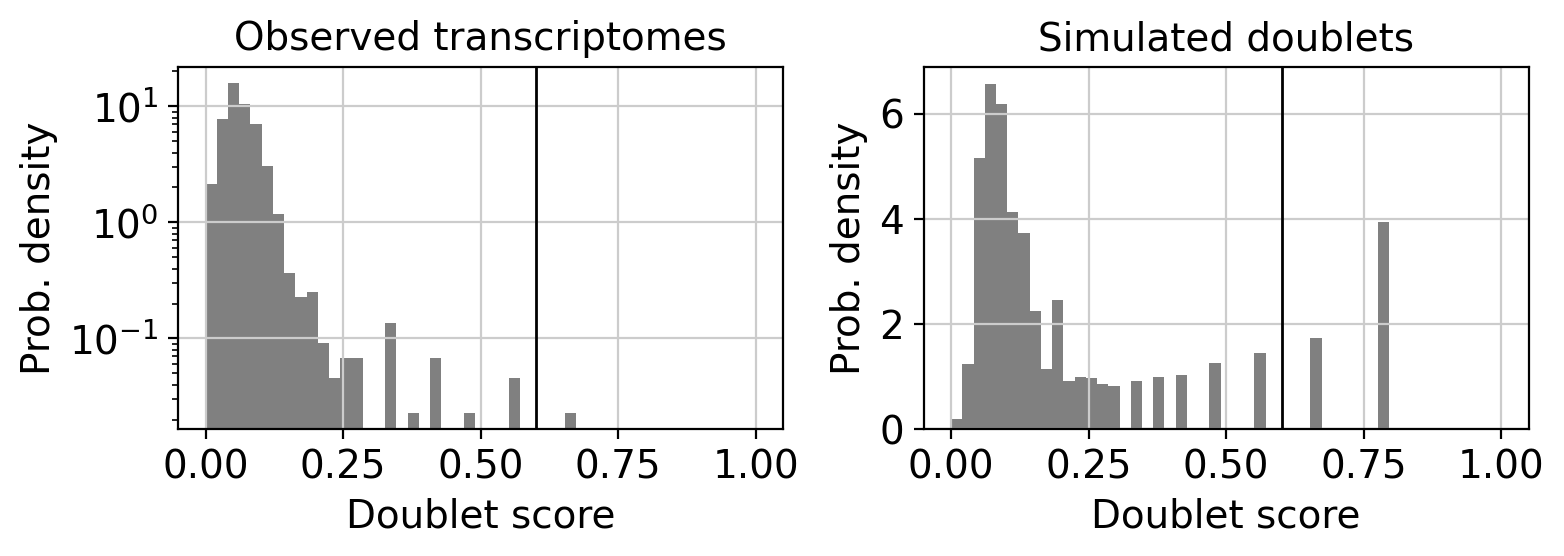

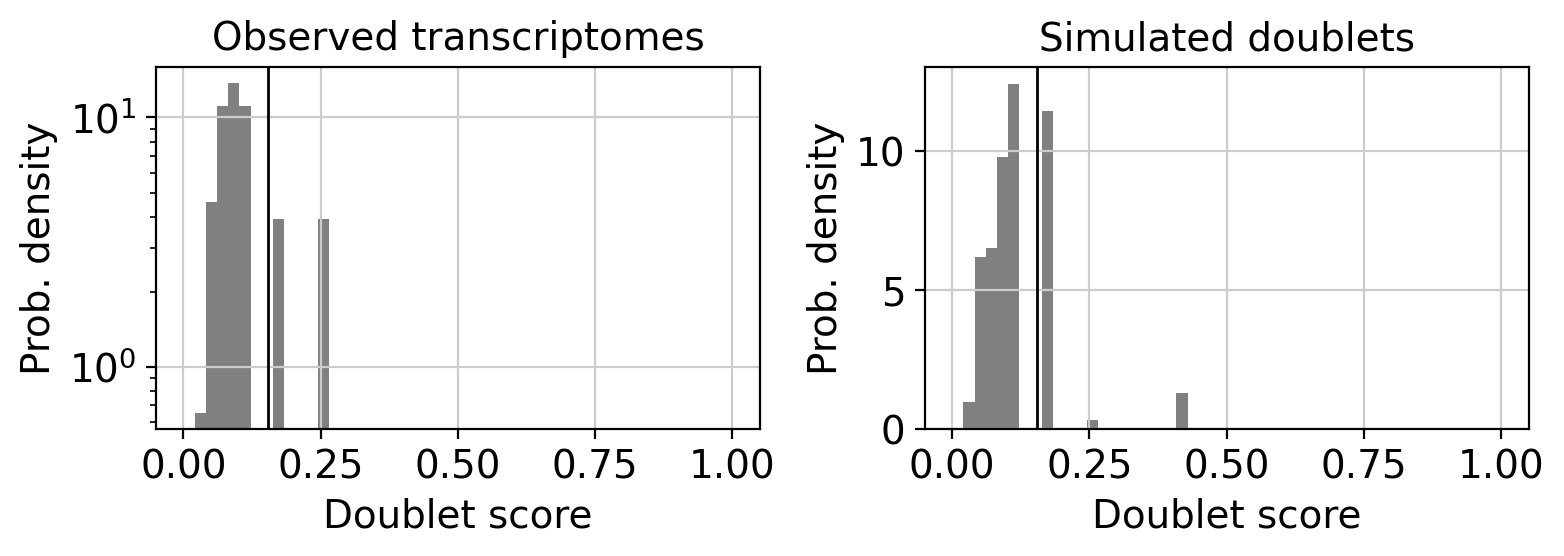

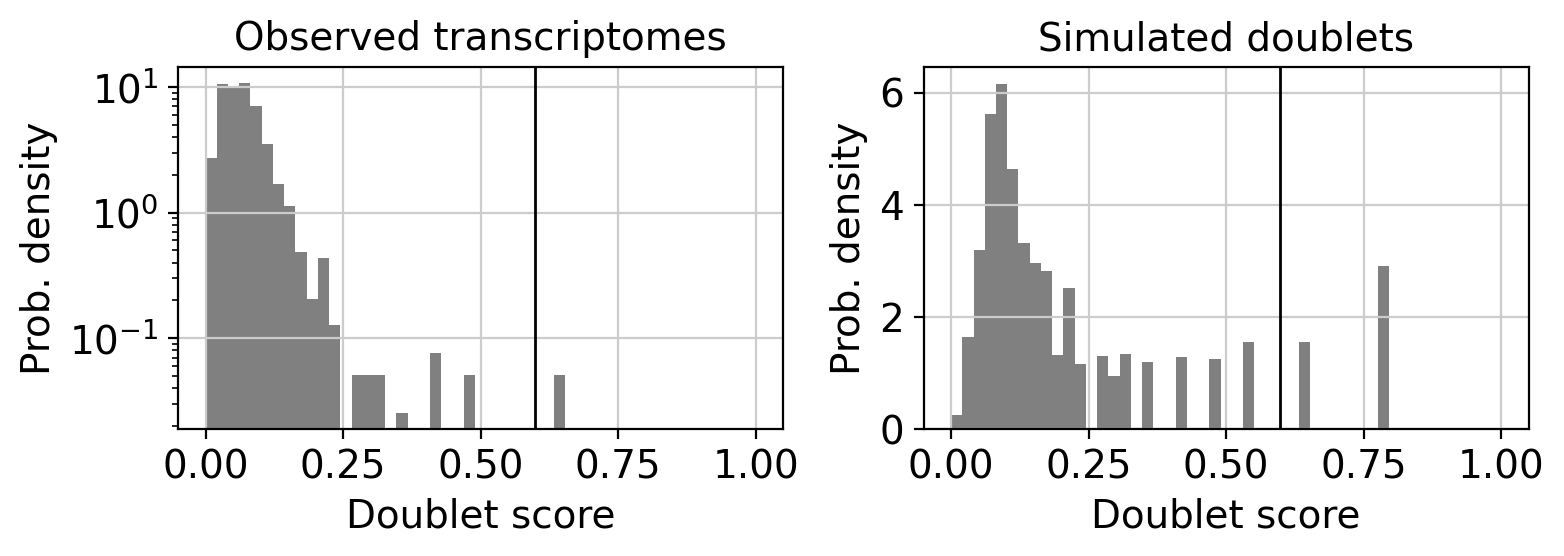

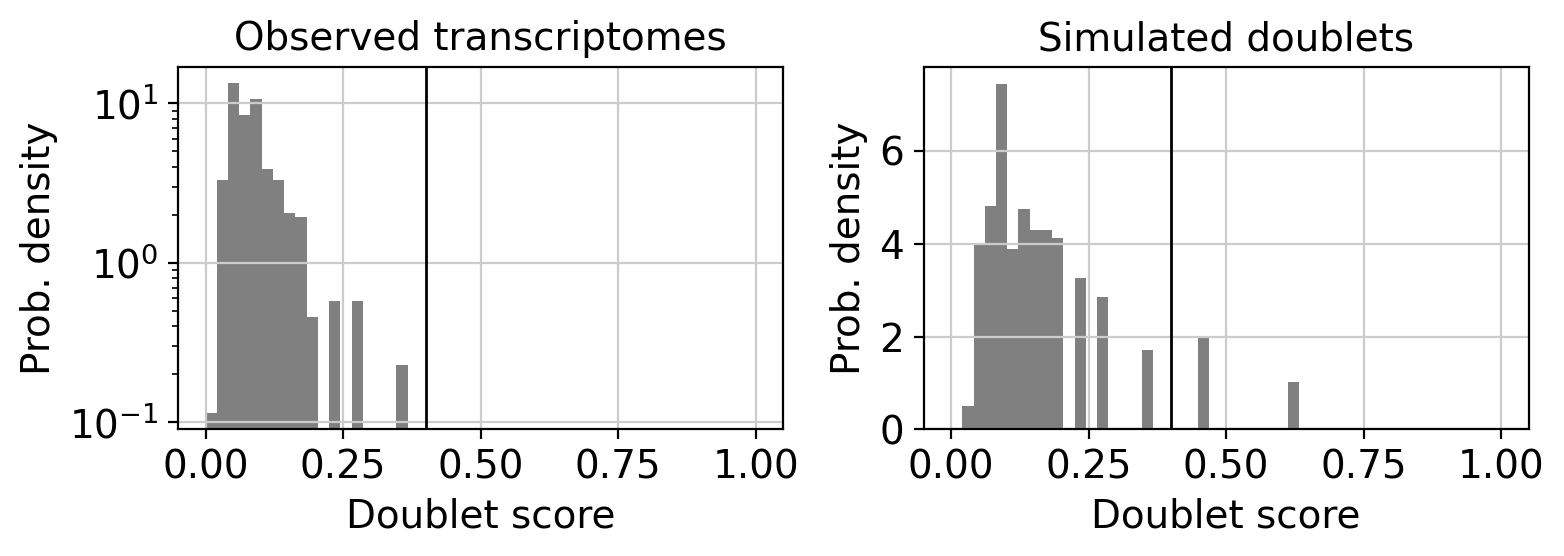

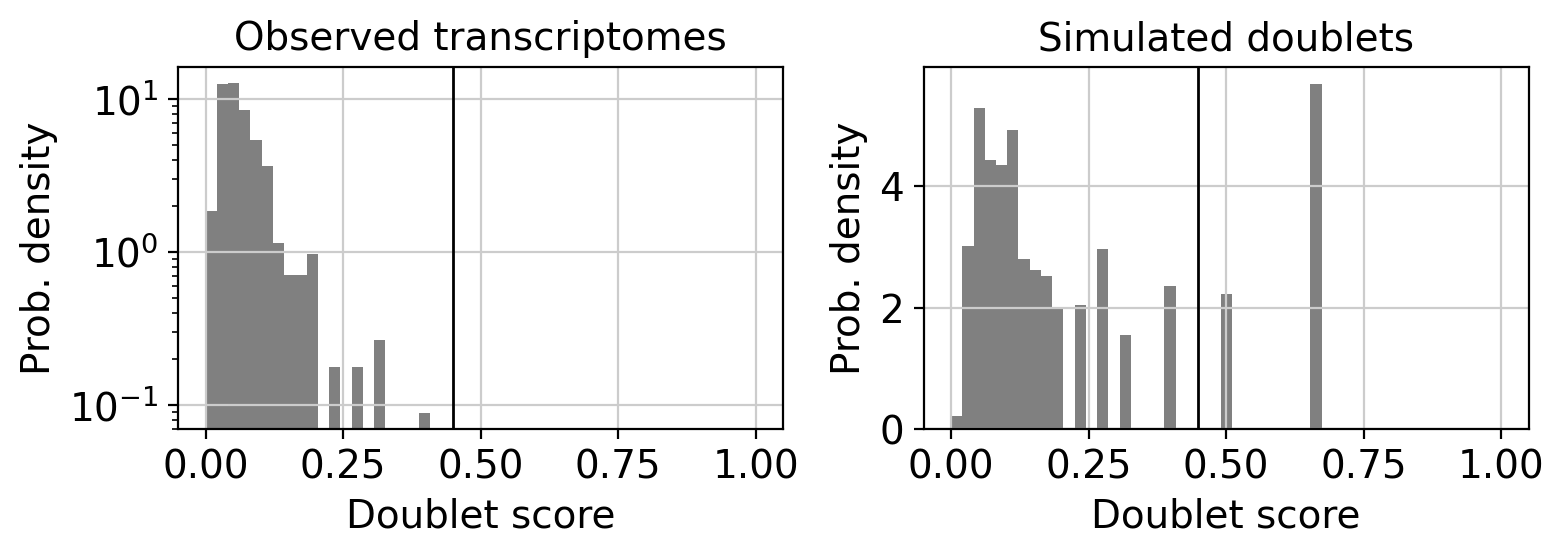

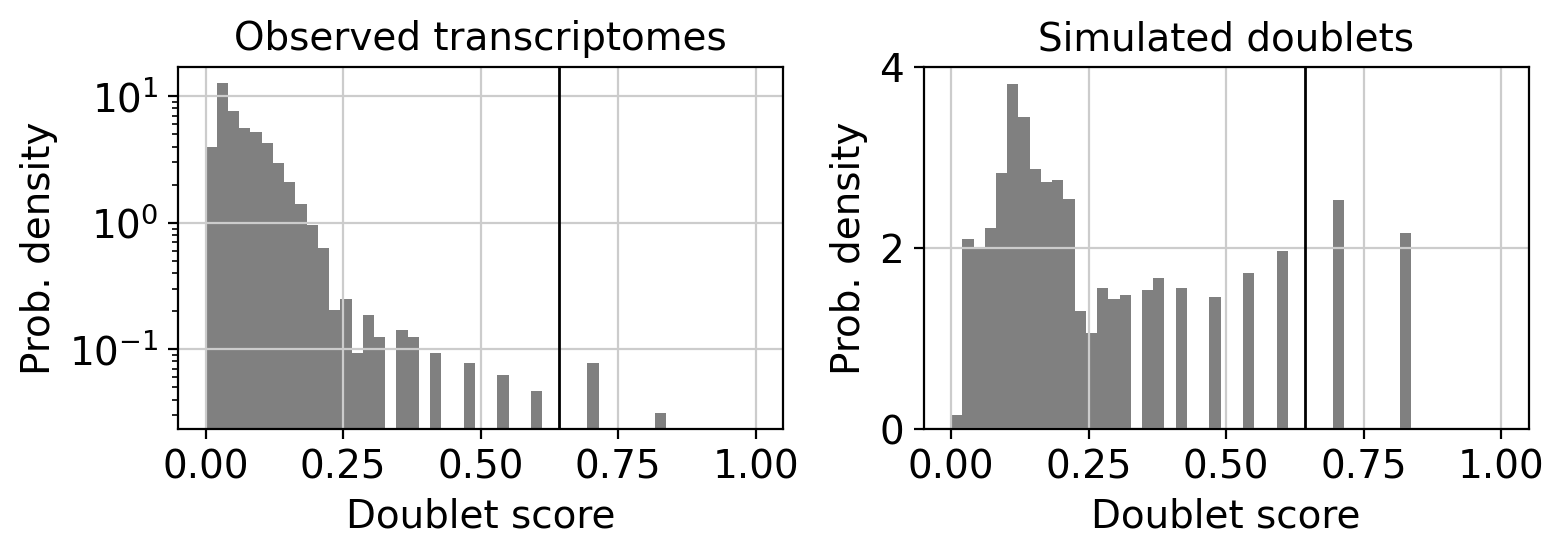

In [11]:
scrublet_concat = run_scrublet(
    adata, sample_col="Sample", cellbarcode_index_name="Index"
)

In [12]:
scrublet_concat

,Sample,doublet_score,predicted_doublet
Index,,,
KUL21-T_AAACGGGGTCTTCAAG,KUL21-T,0.057011,False
KUL21-T_AAAGATGCATCAGTCA,KUL21-T,0.074468,False
KUL21-T_AAAGATGTCTCTGCTG,KUL21-T,0.051245,False
KUL21-T_AAAGCAAAGCCGTCGT,KUL21-T,0.054054,False
KUL21-T_AAAGCAAAGGATATAC,KUL21-T,0.046025,False
...,...,...,...
KUL19-T_TCGGGACCACATGGGA,KUL19-T,0.108257,False
KUL19-T_TCGTACCTCGTTTATC,KUL19-T,0.163814,False
KUL19-T_TGGCCAGAGGGATACC,KUL19-T,0.132075,False


In [13]:
print(
    "Number of predicted doublets: ",
    scrublet_concat[scrublet_concat["predicted_doublet"] == True].shape[0],
)

Number of predicted doublets:  22


In [14]:
scrublet_concat.to_csv(
    DIR2SAVE.joinpath(scrublet_filename), sep="\t", index=True, header=True
)

In [15]:
## add scores to adata.obs
# add annot to .obs
adata.obs = adata.obs.merge(
    right=scrublet_concat[["doublet_score", "predicted_doublet"]],
    how="left",
    right_index=True,
    left_index=True,
)

### Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

In [16]:
# find genes that are mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# find genes that are ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# compute QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=False, percent_top=None
)

In [17]:
print(
    adata.obs[
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]
    ].describe()
)

print(adata.var[["n_cells_by_counts", "total_counts"]].describe())

       n_genes_by_counts  total_counts  pct_counts_mt  pct_counts_ribo
count        8254.000000   8254.000000    8254.000000      8254.000000
mean         1917.547492   7795.234375       6.455045        26.286959
std          1307.092614   7891.291016       4.434261        11.749409
min           201.000000   1002.000000       0.067568         0.702189
25%           935.000000   2589.000000       3.390629        18.172811
50%          1435.000000   4467.500000       5.068784        24.575170
75%          2688.500000  10361.250000       8.337885        33.930736
max          5998.000000  50908.000000      19.983486        77.814034
       n_cells_by_counts  total_counts
count       33694.000000  3.369400e+04
mean          469.740518  1.909594e+03
std           991.726588  1.978998e+04
min             0.000000  0.000000e+00
25%             0.000000  0.000000e+00
50%            24.000000  2.700000e+01
75%           514.000000  6.440000e+02
max          8235.000000  1.870132e+06


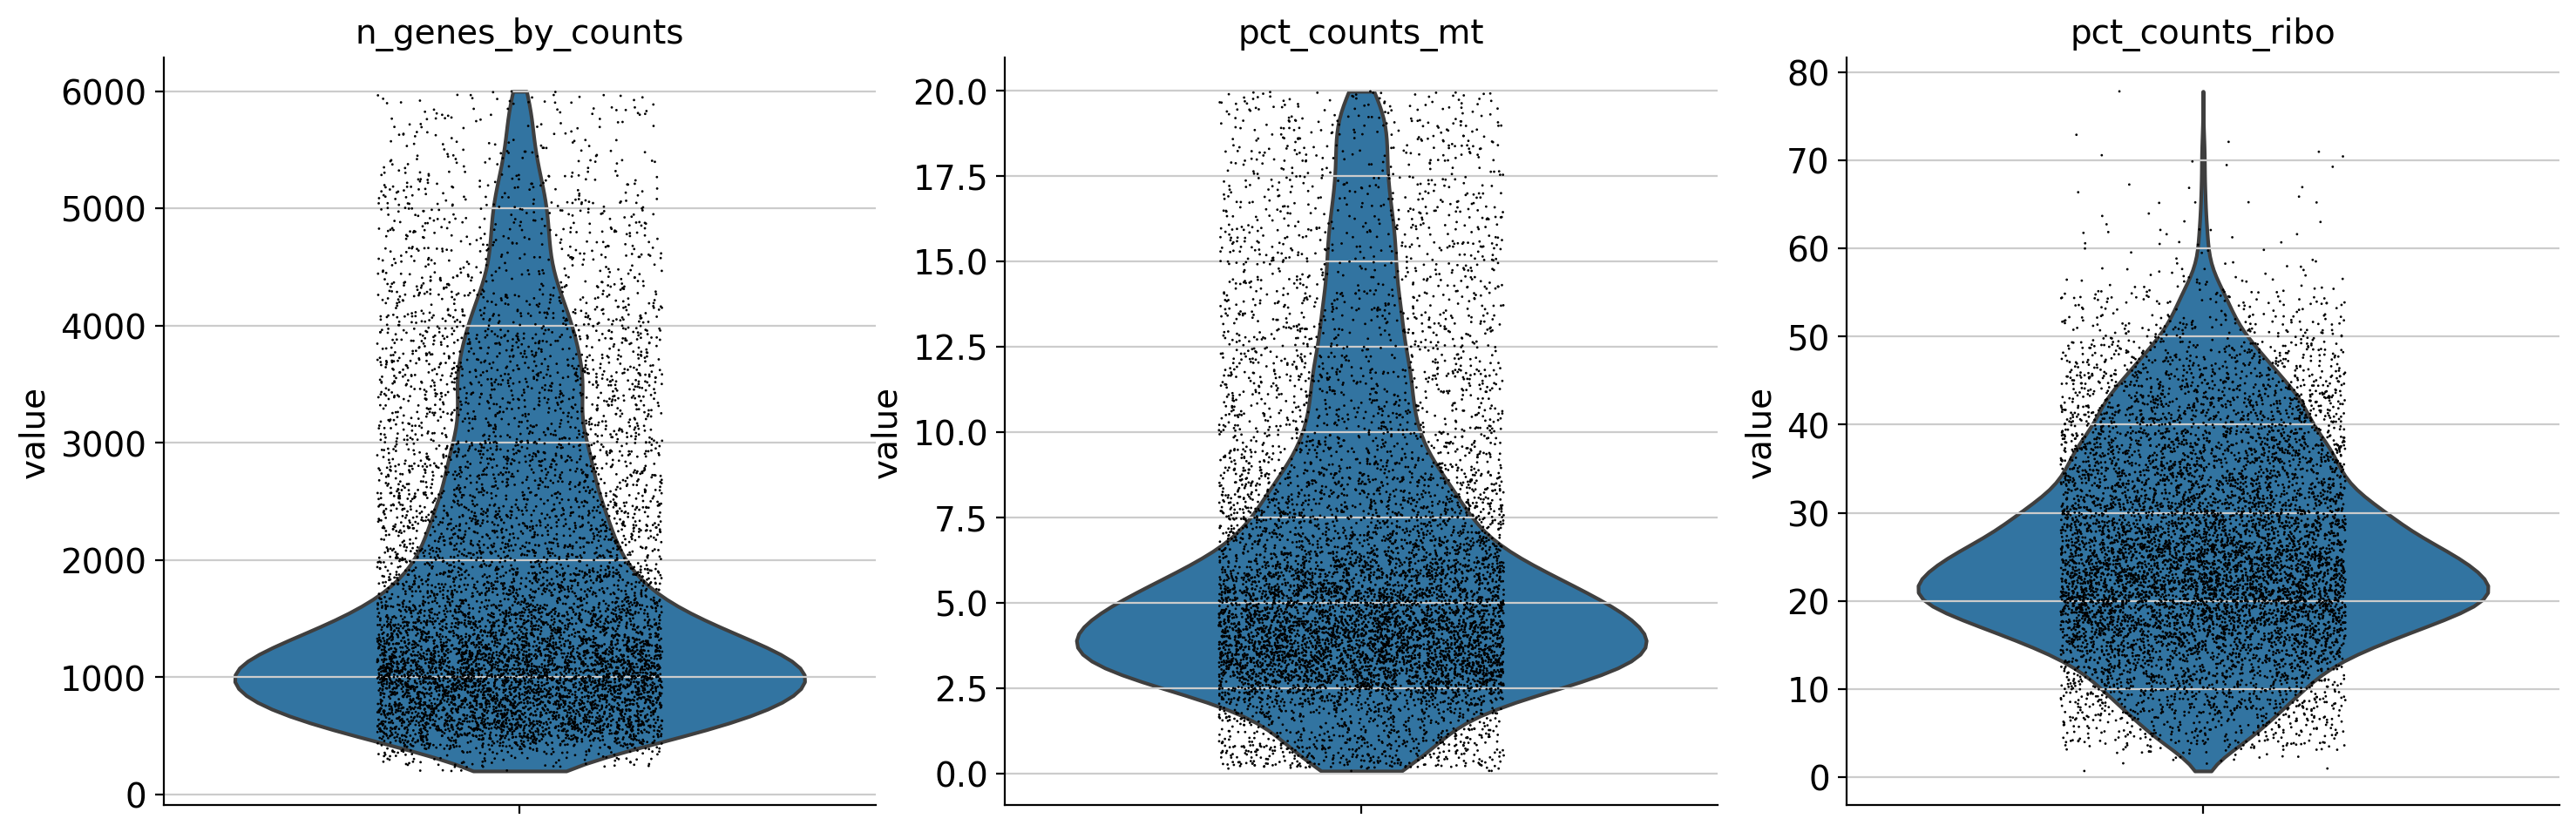

In [18]:
# violin plot of some distributions
sc.pl.violin(
    adata,
    keys=["n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.2,
    multi_panel=True,
    rotation=30,
    save="Lee2020_KUL_CRC_QC_covariates.pdf",
    show=True,
)

#### Filter cells according to identified QC thresholds:

* set threshold MT percent to 10%
* remove ribosomal and mitochondrial genes 
* remove cells with less than 300 genes

In [19]:
#### Filter cells according to identified QC thresholds:
print("Total number of cells: {:d}".format(adata.n_obs))

# remove cells with more than 20% MT genes
adata = adata[adata.obs.pct_counts_mt < 20, :].copy()
print("Number of cells after mt filter: {:d}".format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes=300)
print("Number of cells after gene filter: {:d}".format(adata.n_obs))

Total number of cells: 8254
Number of cells after mt filter: 8254
Number of cells after gene filter: 8212


#### Remove mt and ribo genes

In [20]:
print(adata.shape[1])
adata = adata[:, ~adata.var["mt"].values]
print("After mt genes removal: ", adata.shape[1])
adata = adata[:, ~adata.var["ribo"].values]
print("After ribo genes removal: ", adata.shape[1])

33694
After mt genes removal:  33681
After ribo genes removal:  33578


### Save to file 

In [21]:
adata.write(DIR2SAVE.joinpath("Lee2020_KUL_CRC_raw_scrublet_qc.h5ad"))

In [22]:
DIR2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/20mt/scrublet_qc')